In [3]:
import tensorflow as tf
import os
tf.__version__

'2.13.0'

In [15]:
def load_audio(file_path, sample_rate=44100):
    # Load audio at 44.1kHz sample-rate
    audio = tf.io.read_file(file_path)
    audio, sample_rate = tf.audio.decode_wav(audio, desired_channels=-1, desired_samples=sample_rate)

    return tf.transpose(audio)

prefix = "../../input_data/data_speech_commands_v0.02/zero/"

paths = [os.path.join(prefix, path) for path in os.listdir(prefix)]

paths

['../../input_data/data_speech_commands_v0.02/zero/004ae714_nohash_0.wav',
 '../../input_data/data_speech_commands_v0.02/zero/004ae714_nohash_1.wav',
 '../../input_data/data_speech_commands_v0.02/zero/01b4757a_nohash_0.wav',
 '../../input_data/data_speech_commands_v0.02/zero/01bb6a2a_nohash_0.wav',
 '../../input_data/data_speech_commands_v0.02/zero/01bb6a2a_nohash_1.wav',
 '../../input_data/data_speech_commands_v0.02/zero/01bb6a2a_nohash_2.wav',
 '../../input_data/data_speech_commands_v0.02/zero/01bb6a2a_nohash_3.wav',
 '../../input_data/data_speech_commands_v0.02/zero/01bb6a2a_nohash_4.wav',
 '../../input_data/data_speech_commands_v0.02/zero/01bcfc0c_nohash_0.wav',
 '../../input_data/data_speech_commands_v0.02/zero/01bcfc0c_nohash_1.wav',
 '../../input_data/data_speech_commands_v0.02/zero/01bcfc0c_nohash_2.wav',
 '../../input_data/data_speech_commands_v0.02/zero/02ade946_nohash_0.wav',
 '../../input_data/data_speech_commands_v0.02/zero/02ade946_nohash_1.wav',
 '../../input_data/data_s

Text(0, 0.5, 'Value')

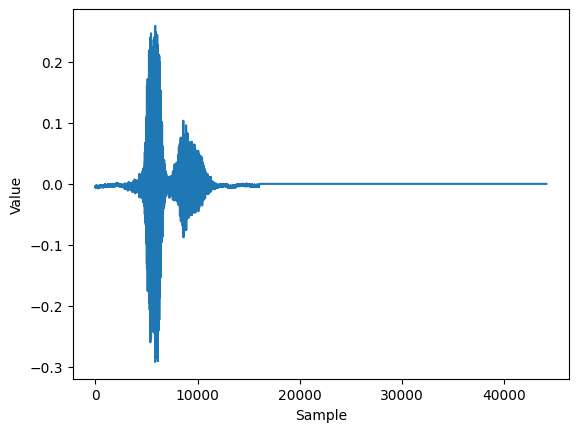

In [12]:
import matplotlib.pyplot as plt

# Plot the first file in the set of audio data
audio = load_audio(paths[0])
plt.plot(audio.numpy().T)
plt.xlabel('Sample')
plt.ylabel('Value')

Text(0, 0.5, 'Sample Value')

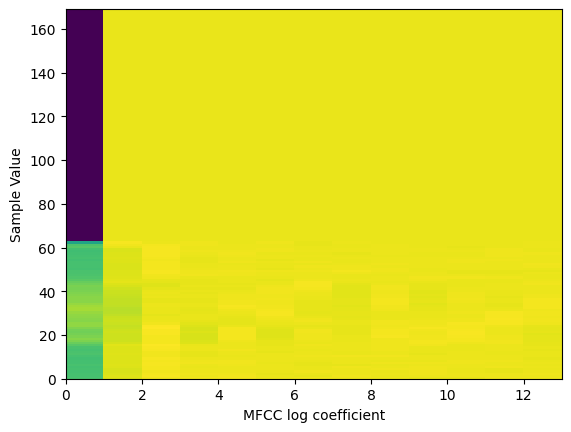

In [13]:
# Use mel weight matrixes and take the log of the mel spectrogram to use to generate MFCCs
def apply_mfccs(audio, sample_rate=44100, num_mfccs=13):

    stfts = tf.signal.stft(audio, frame_length=1024, frame_step=256, fft_length=1024)
    spectrograms = tf.abs(stfts)
    num_spectrogram_bins = stfts.shape[-1]#.value
    lower_edge_hertz, upper_edge_hertz, num_mel_bins = 80.0, 7600.0, 80
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(num_mel_bins, num_spectrogram_bins, 
                                                                        sample_rate, lower_edge_hertz, upper_edge_hertz)

    mel_spectrograms = tf.tensordot(spectrograms, linear_to_mel_weight_matrix, 1)
    mel_spectrograms.set_shape(spectrograms.shape[:-1].concatenate(linear_to_mel_weight_matrix.shape[-1:]))
    log_mel_spectrograms = tf.math.log(mel_spectrograms + 1e-6)

    #Compute MFCCs from log_mel_spectrograms
    mfccs = tf.signal.mfccs_from_log_mel_spectrograms(log_mel_spectrograms)[..., :num_mfccs]

    return mfccs

mfcc = apply_mfccs(audio)
plt.pcolor(mfcc.numpy()[0])
plt.xlabel('MFCC log coefficient')
plt.ylabel('Sample Value')

In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

def prep_ds(ds, shuffle_buffer_size=1024, batch_size=64):
    # Randomly shuffle (file_path, label) dataset
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Load and decode audio from file paths
    ds = ds.map(load_audio, num_parallel_calls=AUTOTUNE)
    # generate MFCCs from the audio data
    ds = ds.map(apply_mfccs)
    # Repeat dataset forever
    ds = ds.repeat()
    
    # Prepare batches
    ds = ds.batch(batch_size)
    # Prefetch
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

ds = tf.data.Dataset.from_tensor_slices(paths)
train_ds = prep_ds(ds)

for x in train_ds.take(1):
    print(x)

tf.Tensor(
[[[[-4.2647541e+01  2.0504270e+00  1.7441279e+00 ...  1.6621660e+00
    -4.5235884e-01 -5.3046018e-01]
   [-4.3092941e+01  2.4717867e+00  1.8570634e+00 ...  7.7413023e-01
    -5.7510734e-01  4.4748715e-01]
   [-4.3594463e+01  2.3374186e+00  3.0281806e+00 ...  3.9712787e-01
    -9.8050117e-01 -2.5630322e-01]
   ...
   [-1.7475427e+02 -7.8259567e-05  8.2965726e-06 ...  8.8049037e-06
     6.4839332e-06 -2.2959596e-06]
   [-1.7475427e+02 -7.8259567e-05  8.2965726e-06 ...  8.8049037e-06
     6.4839332e-06 -2.2959596e-06]
   [-1.7475427e+02 -7.8259567e-05  8.2965726e-06 ...  8.8049037e-06
     6.4839332e-06 -2.2959596e-06]]]


 [[[-3.5423435e+01  2.9133263e-01  2.0521686e+00 ... -2.6207510e-01
    -6.1092180e-01 -3.4680039e-01]
   [-3.6168888e+01 -9.2904353e-01  8.5700196e-01 ... -1.4546257e-01
    -5.5846870e-01 -6.7539781e-02]
   [-3.5488091e+01 -1.4795039e+00 -2.9147121e-01 ...  1.3209310e-01
    -3.7469563e-01 -1.2585698e-01]
   ...
   [-1.7475427e+02 -7.8259567e-05  8.2965726